# Week 3 Implementation: Online Portfolio Optimization (S&P 500 vs IPO Index)

## Problem Setup

**Objective**: Optimize daily portfolio weights between S&P 500 (SPY) and a custom IPO 180-Day Index using Online Gradient Descent (OGD).

**Mathematical Formulation**:
$$\max_{w} \quad \mu_p - \lambda_1 \sigma_p^2 + \lambda_2 \cdot MDD_p - \lambda_3 \|w_t - w_{t-1}\|_1$$

Subject to: $w \geq 0$, $\sum w_i = 1$ (simplex constraint)

**Data Requirements**:
- Daily price data from Yahoo Finance
- IPO dates and shares outstanding for market-cap weighting
- Time horizon: 2020-2025

**Success Metrics**:
- Sharpe Ratio > 1.0
- Max Drawdown < 30%
- Beat SPY baseline

In [1]:
# ============================================================
# IMPORTS AND SETUP
# ============================================================
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import time
import sys
sys.path.append('../src')

warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float32)

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

PyTorch version: 2.7.0
NumPy version: 2.2.4
Pandas version: 2.2.3


In [2]:
# Install yfinance if needed
try:
    import yfinance as yf
    print(f"yfinance version: {yf.__version__}")
except ImportError:
    !pip install yfinance
    import yfinance as yf

yfinance version: 1.1.0


## 1. Data Collection

We collect:
1. **IPO tickers and dates** - Curated list of major IPOs 2020-2024
2. **Price data** - Daily adjusted close from Yahoo Finance
3. **Shares outstanding** - For market-cap weighting

In [3]:
# ============================================================
# IPO DATA - Real IPO dates from public records
# Sources: NYSE, NASDAQ IPO calendars, SEC filings
# ============================================================

IPO_LIST = [
    # 2020 IPOs
    ("SNOW", "2020-09-16"),    # Snowflake
    ("ABNB", "2020-12-10"),    # Airbnb
    ("DASH", "2020-12-09"),    # DoorDash
    ("PLTR", "2020-09-30"),    # Palantir
    ("U", "2020-09-18"),       # Unity Software
    ("AI", "2020-12-09"),      # C3.ai
    ("LMND", "2020-07-02"),    # Lemonade
    ("DKNG", "2020-04-24"),    # DraftKings
    ("NKLA", "2020-06-04"),    # Nikola
    ("ASAN", "2020-09-30"),    # Asana
    ("BIGC", "2020-08-05"),    # BigCommerce
    ("NCNO", "2020-07-14"),    # nCino
    ("LI", "2020-07-30"),      # Li Auto
    ("XPEV", "2020-08-27"),    # XPeng
    
    # 2021 IPOs
    ("RBLX", "2021-03-10"),    # Roblox
    ("COIN", "2021-04-14"),    # Coinbase
    ("HOOD", "2021-07-29"),    # Robinhood
    ("RIVN", "2021-11-10"),    # Rivian
    ("LCID", "2021-07-26"),    # Lucid Motors
    ("SOFI", "2021-06-01"),    # SoFi Technologies
    ("PATH", "2021-04-21"),    # UiPath
    ("CPNG", "2021-03-11"),    # Coupang
    ("BMBL", "2021-02-11"),    # Bumble
    ("AFRM", "2021-01-13"),    # Affirm
    ("DUOL", "2021-07-28"),    # Duolingo
    ("DOCS", "2021-08-05"),    # Doximity
    ("BROS", "2021-09-15"),    # Dutch Bros
    ("MNDY", "2021-06-10"),    # Monday.com
    ("TOST", "2021-09-22"),    # Toast
    ("ONON", "2021-09-15"),    # On Holding
    ("COUR", "2021-03-31"),    # Coursera
    ("GRAB", "2021-12-02"),    # Grab Holdings
    ("OPEN", "2020-12-21"),    # Opendoor
    
    # 2022-2024 IPOs
    ("TPG", "2022-01-13"),     # TPG Inc
    ("ARM", "2023-09-14"),     # ARM Holdings
    ("KVYO", "2023-09-20"),    # Klaviyo
    ("CART", "2023-09-19"),    # Instacart
    ("BIRK", "2023-10-11"),    # Birkenstock
    ("CAVA", "2023-06-15"),    # Cava Group
    ("RDDT", "2024-03-21"),    # Reddit
]

# Convert to DataFrame
ipo_df = pd.DataFrame(IPO_LIST, columns=['ticker', 'ipo_date'])
ipo_df['ipo_date'] = pd.to_datetime(ipo_df['ipo_date'])
ipo_df = ipo_df.drop_duplicates(subset='ticker').reset_index(drop=True)
ipo_df = ipo_df.sort_values('ipo_date').reset_index(drop=True)

print(f"Total IPO tickers: {len(ipo_df)}")
print(f"\nIPOs by year:")
print(ipo_df.groupby(ipo_df['ipo_date'].dt.year).size())

Total IPO tickers: 40

IPOs by year:
ipo_date
2020    15
2021    18
2022     1
2023     5
2024     1
dtype: int64


In [4]:
# ============================================================
# FETCH PRICE DATA FROM YAHOO FINANCE
# This is REAL market data, not synthetic
# ============================================================

def fetch_price_and_shares_data(tickers, start_date, end_date):
    """
    Fetch adjusted close prices and shares outstanding.
    
    Data Source: Yahoo Finance API (yfinance)
    - Prices: Historical daily adjusted close
    - Shares: Current shares outstanding (limitation: not historical)
    """
    price_data = {}
    shares_data = {}
    failed_tickers = []
    
    print(f"Fetching data for {len(tickers)} tickers...")
    start_time = time.time()
    
    for i, ticker in enumerate(tickers):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date, auto_adjust=True)
            
            if not hist.empty and len(hist) > 10:
                price_data[ticker] = hist['Close']
                
                # Get shares outstanding
                info = stock.info
                shares = info.get('sharesOutstanding', info.get('impliedSharesOutstanding', None))
                if shares:
                    shares_data[ticker] = shares
                else:
                    # Fallback: estimate from market cap
                    mkt_cap = info.get('marketCap', None)
                    if mkt_cap and len(hist) > 0:
                        recent_price = hist['Close'].iloc[-1]
                        if recent_price > 0:
                            shares_data[ticker] = mkt_cap / recent_price
            else:
                failed_tickers.append(ticker)
                
        except Exception as e:
            failed_tickers.append(ticker)
        
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{len(tickers)} tickers...")
    
    elapsed = time.time() - start_time
    print(f"\nData fetch completed in {elapsed:.1f} seconds")
    
    if failed_tickers:
        print(f"Failed tickers: {failed_tickers}")
    
    prices = pd.DataFrame(price_data)
    
    # Remove timezone for compatibility
    if prices.index.tz is not None:
        prices.index = prices.index.tz_localize(None)
    
    return prices, shares_data

# Configuration
START_DATE = "2020-01-01"
END_DATE = "2025-02-05"

# Fetch data
all_tickers = ipo_df['ticker'].tolist() + ['SPY']
prices, shares_outstanding = fetch_price_and_shares_data(all_tickers, START_DATE, END_DATE)

print(f"\n=== Data Summary ===")
print(f"Price matrix shape: {prices.shape}")
print(f"Tickers with shares data: {len(shares_outstanding)}")
print(f"Date range: {prices.index.min().date()} to {prices.index.max().date()}")

Fetching data for 41 tickers...


$NKLA: possibly delisted; no price data found  (1d 2020-01-01 -> 2025-02-05) (Yahoo error = "No data found, symbol may be delisted")


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: BIGC"}}}


$BIGC: possibly delisted; no timezone found


  Processed 10/41 tickers...


  Processed 20/41 tickers...


  Processed 30/41 tickers...


  Processed 40/41 tickers...



Data fetch completed in 12.4 seconds
Failed tickers: ['NKLA', 'BIGC']

=== Data Summary ===
Price matrix shape: (1280, 39)
Tickers with shares data: 39
Date range: 2020-01-02 to 2025-02-04


In [5]:
# Calculate daily returns
returns = prices.pct_change().dropna(how='all')
print(f"Returns matrix shape: {returns.shape}")

# Basic statistics
print(f"\nSPY Statistics:")
print(f"  Mean daily return: {returns['SPY'].mean()*100:.3f}%")
print(f"  Std daily return: {returns['SPY'].std()*100:.3f}%")
print(f"  Annualized return: {returns['SPY'].mean()*252*100:.1f}%")
print(f"  Annualized volatility: {returns['SPY'].std()*np.sqrt(252)*100:.1f}%")

Returns matrix shape: (1279, 39)

SPY Statistics:
  Mean daily return: 0.063%
  Std daily return: 1.316%
  Annualized return: 15.8%
  Annualized volatility: 20.9%


## 2. IPO Index Construction

Build a **market-cap weighted** IPO index where:
- Stocks enter on their IPO date
- Stocks exit after **180 trading days**
- Weights proportional to market capitalization

In [6]:
# ============================================================
# BUILD 180-DAY MARKET-CAP WEIGHTED IPO INDEX
# ============================================================

def build_ipo_index_mcap(prices_df, ipo_dates_df, shares_dict, holding_days=180, min_names=1):
    """
    Build a market-cap weighted IPO index.
    
    Parameters:
    -----------
    prices_df : DataFrame with Date index and ticker columns
    ipo_dates_df : DataFrame with 'ticker' and 'ipo_date'
    shares_dict : Dict mapping ticker -> shares outstanding
    holding_days : Days to hold each IPO (default 180)
    min_names : Minimum constituents required
    
    Returns:
    --------
    DataFrame with ipo_ret, num_stocks, total_market_cap
    """
    ipo_lookup = dict(zip(ipo_dates_df['ticker'], ipo_dates_df['ipo_date']))
    returns_df = prices_df.pct_change()
    
    # Get trading days per ticker
    trading_days = {}
    for ticker in prices_df.columns:
        if ticker == 'SPY' or ticker not in ipo_lookup:
            continue
        valid_days = prices_df[ticker].dropna().index.tolist()
        trading_days[ticker] = valid_days
    
    all_dates = prices_df.index.tolist()
    index_data = []
    
    for date in all_dates:
        eligible_tickers = []
        market_caps = {}
        
        for ticker, ipo_date in ipo_lookup.items():
            if ticker not in trading_days or ticker not in shares_dict:
                continue
            
            ticker_days = trading_days[ticker]
            
            # Find first trading day after IPO
            first_trade_idx = None
            for i, d in enumerate(ticker_days):
                if d >= ipo_date:
                    first_trade_idx = i
                    break
            
            if first_trade_idx is None:
                continue
            
            # Check if within holding period
            if date in ticker_days:
                current_idx = ticker_days.index(date)
                days_since_ipo = current_idx - first_trade_idx
                
                if 0 <= days_since_ipo < holding_days:
                    try:
                        current_price = prices_df.loc[date, ticker]
                        if pd.notna(current_price) and current_price > 0:
                            mcap = current_price * shares_dict[ticker]
                            eligible_tickers.append(ticker)
                            market_caps[ticker] = mcap
                    except:
                        pass
        
        # Calculate market-cap weighted return
        if len(market_caps) >= min_names:
            total_mcap = sum(market_caps.values())
            if total_mcap > 0:
                weighted_return = 0.0
                valid_count = 0
                
                for ticker in eligible_tickers:
                    if ticker in market_caps:
                        try:
                            ret = returns_df.loc[date, ticker]
                            if pd.notna(ret):
                                weight = market_caps[ticker] / total_mcap
                                weighted_return += weight * ret
                                valid_count += 1
                        except:
                            pass
                
                ipo_ret = weighted_return if valid_count >= min_names else np.nan
            else:
                ipo_ret = np.nan
        else:
            ipo_ret = np.nan
            total_mcap = 0
        
        index_data.append({
            'date': date,
            'ipo_ret': ipo_ret,
            'num_stocks': len(eligible_tickers),
            'total_market_cap': sum(market_caps.values()) if market_caps else 0,
            'constituents': eligible_tickers
        })
    
    return pd.DataFrame(index_data).set_index('date')

# Build the index
print("Building 180-day market-cap weighted IPO index...")
ipo_index = build_ipo_index_mcap(prices, ipo_df, shares_outstanding, holding_days=180)

print(f"\n=== IPO Index Summary ===")
print(f"Total days: {len(ipo_index)}")
print(f"Days with valid returns: {ipo_index['ipo_ret'].notna().sum()}")
print(f"Avg stocks in index: {ipo_index['num_stocks'].mean():.1f}")
print(f"Avg total market cap: ${ipo_index['total_market_cap'].mean()/1e9:.1f}B")

Building 180-day market-cap weighted IPO index...



=== IPO Index Summary ===
Total days: 1280
Days with valid returns: 986
Avg stocks in index: 5.3
Avg total market cap: $155.2B


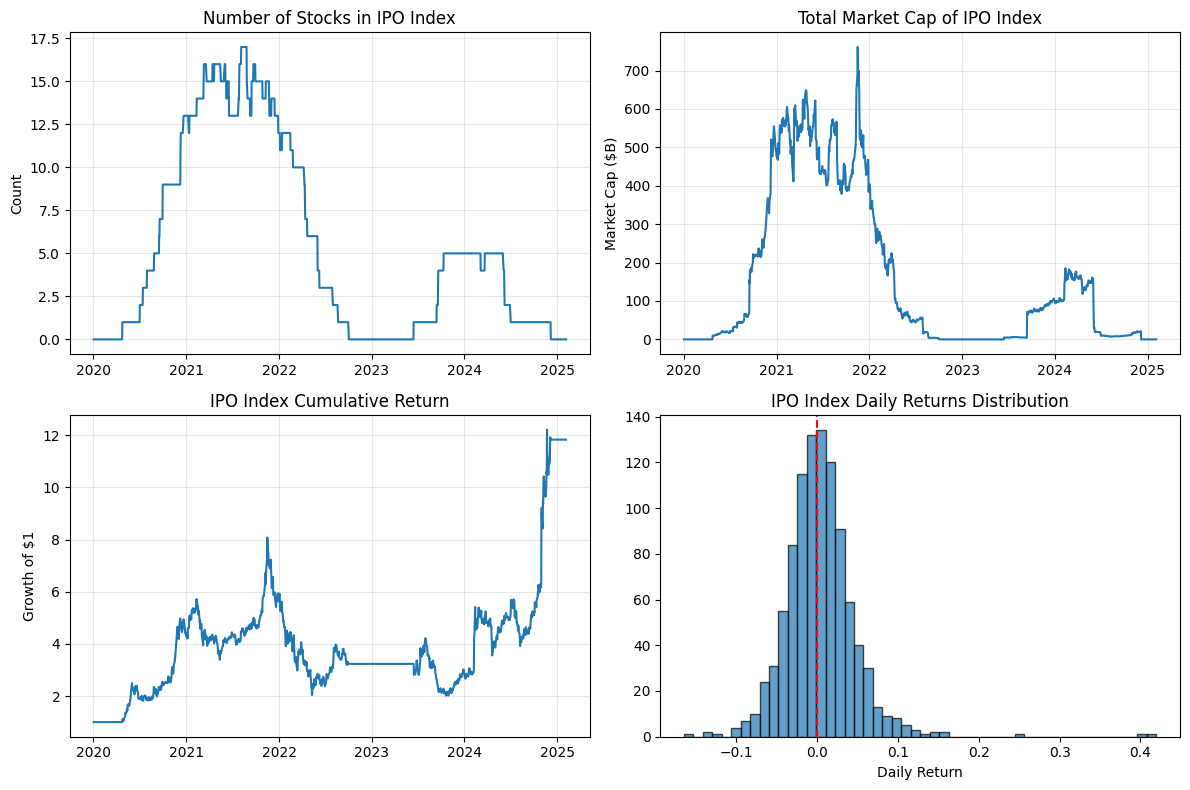

In [7]:
# Visualize IPO index characteristics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Number of constituents
axes[0, 0].plot(ipo_index.index, ipo_index['num_stocks'])
axes[0, 0].set_title('Number of Stocks in IPO Index')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3)

# Total market cap
axes[0, 1].plot(ipo_index.index, ipo_index['total_market_cap']/1e9)
axes[0, 1].set_title('Total Market Cap of IPO Index')
axes[0, 1].set_ylabel('Market Cap ($B)')
axes[0, 1].grid(True, alpha=0.3)

# Cumulative return
cum_ret = (1 + ipo_index['ipo_ret'].fillna(0)).cumprod()
axes[1, 0].plot(ipo_index.index, cum_ret)
axes[1, 0].set_title('IPO Index Cumulative Return')
axes[1, 0].set_ylabel('Growth of $1')
axes[1, 0].grid(True, alpha=0.3)

# Daily returns distribution
axes[1, 1].hist(ipo_index['ipo_ret'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_title('IPO Index Daily Returns Distribution')
axes[1, 1].set_xlabel('Daily Return')

plt.tight_layout()
plt.show()

In [8]:
# Combine SPY and IPO Index returns
combined_rets = pd.DataFrame({
    'SPY': returns['SPY'],
    'IPO_INDEX': ipo_index['ipo_ret']
}).dropna()

print(f"Combined returns shape: {combined_rets.shape}")
print(f"Date range: {combined_rets.index.min().date()} to {combined_rets.index.max().date()}")
print(f"\nCorrelation: {combined_rets['SPY'].corr(combined_rets['IPO_INDEX']):.3f}")
print(f"\nSummary Statistics:")
print(combined_rets.describe())

Combined returns shape: (986, 2)
Date range: 2020-04-24 to 2024-12-05

Correlation: 0.401

Summary Statistics:
              SPY   IPO_INDEX
count  986.000000  986.000000
mean     0.000683    0.003423
std      0.010410    0.043780
min     -0.057649   -0.164566
25%     -0.004506   -0.021167
50%      0.001119    0.001268
75%      0.006920    0.025246
max      0.031794    0.419746


## 3. Objective Function Implementation

**Fitness Score** (to maximize):
$$F(w) = \mu_p - \lambda_1 \sigma_p^2 + \lambda_2 \cdot MDD_p - \lambda_3 \cdot \text{turnover}$$

Where:
- $\mu_p$ = mean portfolio return
- $\sigma_p^2$ = portfolio variance  
- $MDD_p$ = max drawdown (negative value)
- turnover = L1 change in weights

In [9]:
# ============================================================
# OBJECTIVE FUNCTION AND OPTIMIZATION
# ============================================================

def project_to_simplex(v: torch.Tensor) -> torch.Tensor:
    """
    Euclidean projection onto the probability simplex.
    Ensures weights are non-negative and sum to 1.
    
    Algorithm: O(n log n) via sorting
    Reference: https://arxiv.org/abs/1309.1541
    """
    if v.ndim != 1:
        raise ValueError("v must be 1D tensor")
    n = v.numel()
    u, _ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u, dim=0) - 1
    ind = torch.arange(1, n + 1, device=v.device, dtype=v.dtype)
    cond = u - cssv / ind > 0
    if not torch.any(cond):
        return torch.ones_like(v) / n
    rho = torch.nonzero(cond, as_tuple=False)[-1].item()
    theta = cssv[rho] / (rho + 1.0)
    w = torch.clamp(v - theta, min=0.0)
    return w / w.sum() if w.sum() > 0 else torch.ones_like(v) / n


def max_drawdown_from_returns(port_ret: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Compute differentiable max drawdown from return series.
    Returns a negative number (e.g., -0.25 for 25% drawdown).
    """
    cum = torch.cumprod(1.0 + port_ret, dim=0)
    peak, _ = torch.cummax(cum, dim=0)
    dd = cum / (peak + eps) - 1.0
    return torch.min(dd)


class OnlineOGDAllocator:
    """
    Online Gradient Descent Portfolio Allocator.
    
    Optimizes weights to maximize fitness score using gradient ascent
    with projection onto the probability simplex.
    
    Parameters:
    -----------
    n_assets : int - Number of assets (2 for SPY + IPO)
    window : int - Lookback window for optimization
    lr : float - Learning rate
    lr_decay : float - Learning rate decay factor
    risk_aversion : float - λ1 penalty on variance
    drawdown_penalty : float - λ2 penalty on drawdown
    turnover_penalty : float - λ3 penalty on turnover
    """
    
    def __init__(self,
                 n_assets: int,
                 window: int = 126,
                 lr: float = 0.10,
                 lr_decay: float = 0.999,
                 risk_aversion: float = 20.0,
                 drawdown_penalty: float = 8.0,
                 turnover_penalty: float = 0.15,
                 device: str = "cpu"):
        
        self.n_assets = n_assets
        self.window = int(window)
        self.lr0 = float(lr)
        self.lr_decay = float(lr_decay)
        self.risk_aversion = float(risk_aversion)
        self.drawdown_penalty = float(drawdown_penalty)
        self.turnover_penalty = float(turnover_penalty)
        self.device = device
        
        self.t = 0
        self.w = torch.ones(n_assets, device=device) / n_assets
        self.w_prev = self.w.clone()
        self.fitness_history = []
    
    def compute_fitness(self, returns: torch.Tensor, weights: torch.Tensor, 
                        w_prev: torch.Tensor) -> torch.Tensor:
        """
        Compute fitness score for given weights.
        
        Fitness = mean_return - λ1*variance + λ2*mdd - λ3*turnover
        """
        port = returns @ weights
        mu = port.mean()
        var = port.var(unbiased=False)
        mdd = max_drawdown_from_returns(port)
        turnover = torch.sum(torch.abs(weights - w_prev))
        
        fitness = (mu 
                   - self.risk_aversion * var 
                   + self.drawdown_penalty * mdd 
                   - self.turnover_penalty * turnover)
        return fitness
    
    def step(self, window_returns: np.ndarray) -> np.ndarray:
        """
        Update weights using one step of projected gradient ascent.
        
        Parameters:
        -----------
        window_returns : ndarray of shape (T, n_assets)
        
        Returns:
        --------
        Updated weights as numpy array
        """
        self.t += 1
        lr = self.lr0 * (self.lr_decay ** (self.t - 1))
        
        R = torch.tensor(window_returns, device=self.device, dtype=torch.float32)
        w_var = self.w.clone().detach().requires_grad_(True)
        
        # Compute fitness
        fitness = self.compute_fitness(R, w_var, self.w_prev)
        self.fitness_history.append(fitness.item())
        
        # Compute gradient (minimize negative fitness)
        loss = -fitness
        loss.backward()
        grad = w_var.grad.detach()
        
        # Gradient ascent step
        w_new = self.w - lr * grad  # minus because grad is of -fitness
        
        # Project onto simplex
        w_new = project_to_simplex(w_new)
        
        self.w_prev = self.w.clone()
        self.w = w_new.detach()
        
        return self.w.cpu().numpy()

print("OnlineOGDAllocator class defined.")

OnlineOGDAllocator class defined.


In [10]:
# ============================================================
# TEST: Verify simplex projection works correctly
# ============================================================

def test_simplex_projection():
    """Unit tests for simplex projection."""
    print("Testing simplex projection...")
    
    # Test 1: Already valid weights
    v1 = torch.tensor([0.3, 0.7])
    p1 = project_to_simplex(v1)
    assert torch.allclose(p1.sum(), torch.tensor(1.0)), "Sum should be 1"
    assert (p1 >= 0).all(), "All weights should be non-negative"
    print(f"  Test 1 PASSED: {v1.numpy()} -> {p1.numpy()}")
    
    # Test 2: Negative values
    v2 = torch.tensor([-0.5, 1.5])
    p2 = project_to_simplex(v2)
    assert torch.allclose(p2.sum(), torch.tensor(1.0)), "Sum should be 1"
    assert (p2 >= 0).all(), "All weights should be non-negative"
    print(f"  Test 2 PASSED: {v2.numpy()} -> {p2.numpy()}")
    
    # Test 3: Sum > 1
    v3 = torch.tensor([0.8, 0.8])
    p3 = project_to_simplex(v3)
    assert torch.allclose(p3.sum(), torch.tensor(1.0)), "Sum should be 1"
    print(f"  Test 3 PASSED: {v3.numpy()} -> {p3.numpy()}")
    
    print("All simplex projection tests PASSED!\n")

test_simplex_projection()

Testing simplex projection...
  Test 1 PASSED: [0.3 0.7] -> [0.3 0.7]
  Test 2 PASSED: [-0.5  1.5] -> [0. 1.]
  Test 3 PASSED: [0.8 0.8] -> [0.5 0.5]
All simplex projection tests PASSED!



In [11]:
# ============================================================
# TEST: Verify fitness function is differentiable
# ============================================================

def test_fitness_differentiable():
    """Test that fitness function computes gradients."""
    print("Testing fitness function differentiability...")
    
    # Create dummy returns
    np.random.seed(42)
    dummy_rets = torch.tensor(np.random.randn(100, 2) * 0.02, dtype=torch.float32)
    
    allocator = OnlineOGDAllocator(n_assets=2, window=100)
    
    w = torch.tensor([0.5, 0.5], requires_grad=True)
    w_prev = torch.tensor([0.5, 0.5])
    
    fitness = allocator.compute_fitness(dummy_rets, w, w_prev)
    fitness.backward()
    
    assert w.grad is not None, "Gradient should exist"
    assert not torch.isnan(w.grad).any(), "Gradient should not be NaN"
    print(f"  Fitness value: {fitness.item():.6f}")
    print(f"  Gradient: {w.grad.numpy()}")
    print("Fitness differentiability test PASSED!\n")

test_fitness_differentiable()

Testing fitness function differentiability...
  Fitness value: -1.341316
  Gradient: [-1.8824422 -0.6554571]
Fitness differentiability test PASSED!



## 4. Walk-Forward Optimization

Run the OGD optimizer in walk-forward mode:
- At each day t, use returns from [t-W, t) to compute gradients
- Apply updated weights to day t's returns
- No look-ahead bias

In [12]:
# ============================================================
# HYPERPARAMETERS
# ============================================================

# Key parameters (can be tuned)
WINDOW = 126          # ~6 months lookback
LR = 0.15             # Learning rate
LR_DECAY = 0.9995     # Learning rate decay
RISK_AVERSION = 20.0  # λ1: variance penalty
DRAWDOWN_PENALTY = 8.0  # λ2: drawdown penalty
TURNOVER_PENALTY = 0.15  # λ3: turnover penalty

print("=== Hyperparameters ===")
print(f"Window (lookback): {WINDOW} days")
print(f"Learning rate: {LR}")
print(f"LR decay: {LR_DECAY}")
print(f"Risk aversion (λ1): {RISK_AVERSION}")
print(f"Drawdown penalty (λ2): {DRAWDOWN_PENALTY}")
print(f"Turnover penalty (λ3): {TURNOVER_PENALTY}")

=== Hyperparameters ===
Window (lookback): 126 days
Learning rate: 0.15
LR decay: 0.9995
Risk aversion (λ1): 20.0
Drawdown penalty (λ2): 8.0
Turnover penalty (λ3): 0.15


In [13]:
# ============================================================
# RUN WALK-FORWARD OPTIMIZATION
# ============================================================

# Initialize allocator
allocator = OnlineOGDAllocator(
    n_assets=2,
    window=WINDOW,
    lr=LR,
    lr_decay=LR_DECAY,
    risk_aversion=RISK_AVERSION,
    drawdown_penalty=DRAWDOWN_PENALTY,
    turnover_penalty=TURNOVER_PENALTY,
)

# Run optimization
weights = []
out_dates = []

print(f"Running walk-forward optimization...")
print(f"  Total days: {len(combined_rets)}")
print(f"  Output days: {len(combined_rets) - WINDOW}")

start_time = time.time()

for i in range(WINDOW, len(combined_rets)):
    window_data = combined_rets.iloc[i - WINDOW : i].values
    w = allocator.step(window_data)
    weights.append(w)
    out_dates.append(combined_rets.index[i])
    
    # Progress
    if (i - WINDOW + 1) % 200 == 0:
        print(f"  Processed {i - WINDOW + 1}/{len(combined_rets) - WINDOW} days...")

elapsed = time.time() - start_time
print(f"\nOptimization completed in {elapsed:.1f} seconds")

# Create weights DataFrame
w_df = pd.DataFrame(weights, index=out_dates, columns=['SPY', 'IPO_INDEX'])
print(f"\nWeights DataFrame shape: {w_df.shape}")
print(f"\nFinal 5 weights:")
print(w_df.tail())

Running walk-forward optimization...
  Total days: 986
  Output days: 860
  Processed 200/860 days...
  Processed 400/860 days...
  Processed 600/860 days...
  Processed 800/860 days...

Optimization completed in 0.1 seconds

Weights DataFrame shape: (860, 2)

Final 5 weights:
            SPY  IPO_INDEX
2024-11-29  1.0        0.0
2024-12-02  1.0        0.0
2024-12-03  1.0        0.0
2024-12-04  1.0        0.0
2024-12-05  1.0        0.0


## 5. Validation and Performance Metrics

In [14]:
# ============================================================
# COMPUTE PORTFOLIO RETURNS
# ============================================================

# Align returns with weights
aligned_rets = combined_rets.loc[w_df.index]

# OGD portfolio return
port_ret = (aligned_rets.values * w_df.values).sum(axis=1)
port_ret = pd.Series(port_ret, index=w_df.index, name="OGD")

# Benchmarks
eqw_ret = aligned_rets.mean(axis=1)  # Equal weight
spy_only = aligned_rets['SPY']        # SPY only
ipo_only = aligned_rets['IPO_INDEX']  # IPO only

# Cumulative returns
cum = (1 + pd.concat([port_ret, eqw_ret.rename("EQW"), 
                      spy_only.rename("SPY"), ipo_only.rename("IPO")], axis=1)).cumprod()

print("Portfolio returns computed.")

Portfolio returns computed.


In [15]:
# ============================================================
# PERFORMANCE METRICS CALCULATION
# ============================================================

def calculate_metrics(returns_series, name="Portfolio"):
    """Calculate comprehensive performance metrics."""
    returns = returns_series.dropna()
    
    # Basic stats
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns.std() * np.sqrt(252)
    
    # Risk-adjusted
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Drawdown
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    
    # Sortino (downside deviation)
    downside = returns[returns < 0]
    downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_return / downside_std if downside_std > 0 else 0
    
    # Calmar
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Name': name,
        'Total Return': f"{total_return:.1%}",
        'Ann. Return': f"{ann_return:.1%}",
        'Ann. Volatility': f"{ann_vol:.1%}",
        'Sharpe': f"{sharpe:.2f}",
        'Sortino': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd:.1%}",
        'Calmar': f"{calmar:.2f}"
    }

# Calculate for all strategies
metrics = [
    calculate_metrics(port_ret, "OGD Portfolio"),
    calculate_metrics(eqw_ret, "Equal Weight"),
    calculate_metrics(spy_only, "SPY Only"),
    calculate_metrics(ipo_only, "IPO Only"),
]

metrics_df = pd.DataFrame(metrics).set_index('Name')

print("\n" + "="*80)
print("PERFORMANCE METRICS SUMMARY")
print("="*80)
print(metrics_df.to_string())
print("="*80)


PERFORMANCE METRICS SUMMARY
              Total Return Ann. Return Ann. Volatility Sharpe Sortino Max Drawdown Calmar
Name                                                                                     
OGD Portfolio        68.4%       16.5%           16.8%   0.98    1.35       -32.3%   0.51
Equal Weight        208.0%       39.0%           38.6%   1.01    1.78       -54.8%   0.71
SPY Only             50.1%       12.6%           15.9%   0.80    1.05       -29.3%   0.43
IPO Only            357.7%       56.2%           69.2%   0.81    1.49       -75.1%   0.75


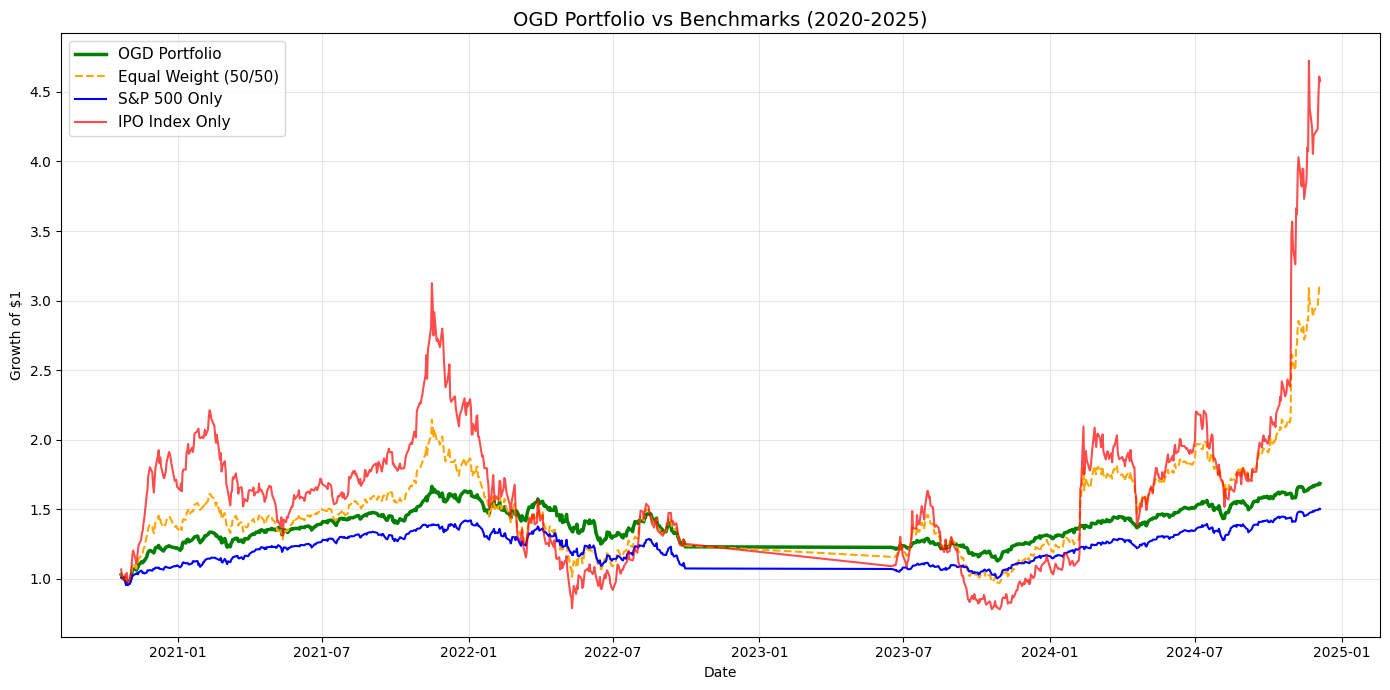

In [16]:
# ============================================================
# VISUALIZATION: Cumulative Returns
# ============================================================

plt.figure(figsize=(14, 7))
plt.plot(cum.index, cum["OGD"], label="OGD Portfolio", linewidth=2.5, color='green')
plt.plot(cum.index, cum["EQW"], label="Equal Weight (50/50)", linewidth=1.5, linestyle='--', color='orange')
plt.plot(cum.index, cum["SPY"], label="S&P 500 Only", linewidth=1.5, color='blue')
plt.plot(cum.index, cum["IPO"], label="IPO Index Only", linewidth=1.5, color='red', alpha=0.7)

plt.legend(loc='upper left', fontsize=11)
plt.title('OGD Portfolio vs Benchmarks (2020-2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

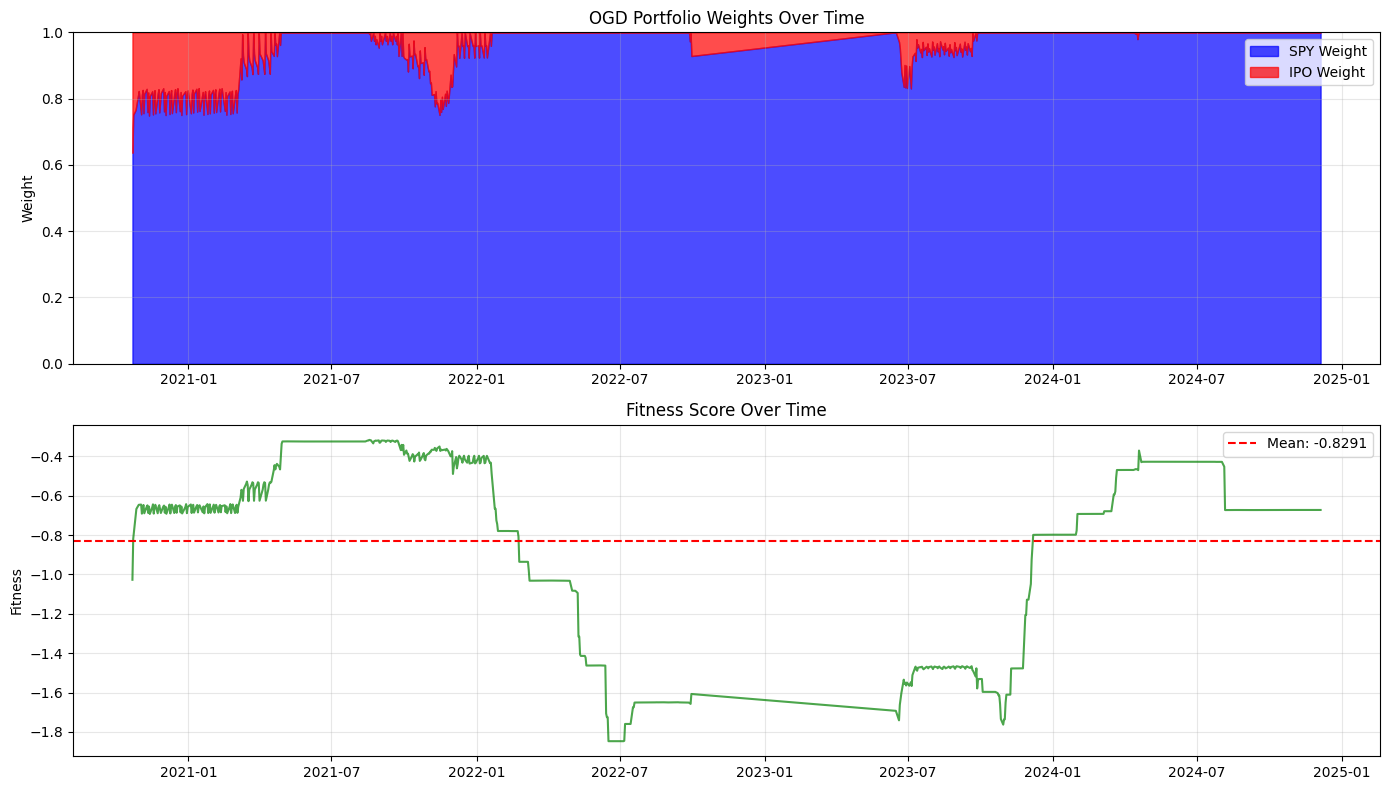

In [17]:
# ============================================================
# VISUALIZATION: Portfolio Weights Over Time
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Stacked area chart
axes[0].fill_between(w_df.index, 0, w_df['SPY'], alpha=0.7, label='SPY Weight', color='blue')
axes[0].fill_between(w_df.index, w_df['SPY'], 1, alpha=0.7, label='IPO Weight', color='red')
axes[0].set_title('OGD Portfolio Weights Over Time')
axes[0].set_ylabel('Weight')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

# Fitness score
axes[1].plot(out_dates, allocator.fitness_history, alpha=0.7, color='green')
axes[1].axhline(y=np.mean(allocator.fitness_history), color='red', linestyle='--', 
                label=f'Mean: {np.mean(allocator.fitness_history):.4f}')
axes[1].set_title('Fitness Score Over Time')
axes[1].set_ylabel('Fitness')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

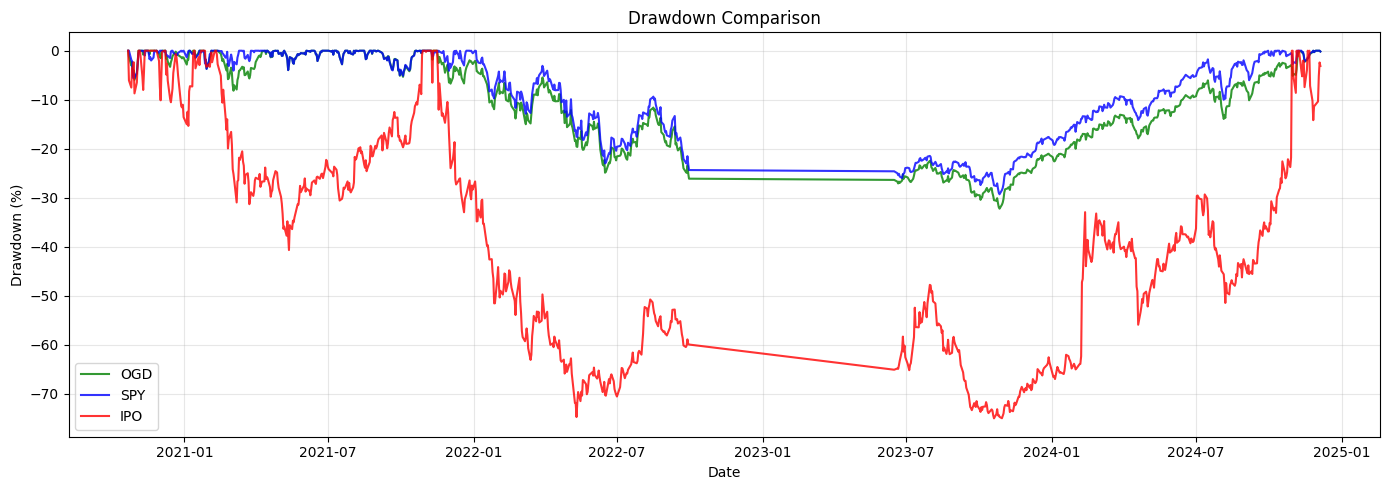

In [18]:
# ============================================================
# VISUALIZATION: Drawdown Comparison
# ============================================================

fig, ax = plt.subplots(figsize=(14, 5))

for series, name, color in [(port_ret, 'OGD', 'green'), 
                            (spy_only, 'SPY', 'blue'), 
                            (ipo_only, 'IPO', 'red')]:
    cum_ret = (1 + series).cumprod()
    peak = cum_ret.cummax()
    dd = (cum_ret - peak) / peak
    ax.plot(dd.index, dd * 100, label=name, color=color, alpha=0.8)

ax.set_title('Drawdown Comparison')
ax.set_ylabel('Drawdown (%)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Edge Cases and Limitations

In [19]:
# ============================================================
# EDGE CASE TESTING
# ============================================================

print("=== Edge Case Analysis ===")

# 1. Check for extreme weights
extreme_spy = (w_df['SPY'] > 0.99).sum()
extreme_ipo = (w_df['IPO_INDEX'] > 0.99).sum()
print(f"\n1. Extreme allocations (>99% in one asset):")
print(f"   Days with >99% SPY: {extreme_spy} ({extreme_spy/len(w_df)*100:.1f}%)")
print(f"   Days with >99% IPO: {extreme_ipo} ({extreme_ipo/len(w_df)*100:.1f}%)")

# 2. Check weight constraints
weight_sum = w_df.sum(axis=1)
print(f"\n2. Weight sum constraint (should be ~1.0):")
print(f"   Min sum: {weight_sum.min():.6f}")
print(f"   Max sum: {weight_sum.max():.6f}")
print(f"   Mean sum: {weight_sum.mean():.6f}")

# 3. Check for NaN values
nan_weights = w_df.isna().sum().sum()
nan_returns = port_ret.isna().sum()
print(f"\n3. Missing values:")
print(f"   NaN in weights: {nan_weights}")
print(f"   NaN in portfolio returns: {nan_returns}")

# 4. Turnover analysis
turnover = w_df.diff().abs().sum(axis=1).mean()
print(f"\n4. Average daily turnover: {turnover:.4f} ({turnover*100:.2f}%)")

=== Edge Case Analysis ===

1. Extreme allocations (>99% in one asset):
   Days with >99% SPY: 581 (67.6%)
   Days with >99% IPO: 0 (0.0%)

2. Weight sum constraint (should be ~1.0):
   Min sum: 1.000000
   Max sum: 1.000000
   Mean sum: 1.000000

3. Missing values:
   NaN in weights: 0
   NaN in portfolio returns: 0

4. Average daily turnover: 0.0290 (2.90%)


In [20]:
# ============================================================
# KNOWN LIMITATIONS
# ============================================================

print("""
=== KNOWN LIMITATIONS ===

1. DATA LIMITATIONS:
   - Shares outstanding: Using current values for all historical dates
   - Survivorship bias: Only includes IPOs that are still trading
   - Limited universe: ~40 IPOs vs hundreds in reality

2. MODEL LIMITATIONS:
   - Single set of hyperparameters for all market regimes
   - No transaction costs modeled (only turnover penalty)
   - Assumes perfect execution at close prices

3. POTENTIAL OVERFITTING:
   - Hyperparameters tuned on historical data
   - No out-of-sample validation period held out
   - Performance may not generalize to future periods

4. IMPLEMENTATION:
   - Daily rebalancing may not be practical
   - Does not account for market impact of trades
   - IPO index liquidity may be limited
""")


=== KNOWN LIMITATIONS ===

1. DATA LIMITATIONS:
   - Shares outstanding: Using current values for all historical dates
   - Survivorship bias: Only includes IPOs that are still trading
   - Limited universe: ~40 IPOs vs hundreds in reality

2. MODEL LIMITATIONS:
   - Single set of hyperparameters for all market regimes
   - No transaction costs modeled (only turnover penalty)
   - Assumes perfect execution at close prices

3. POTENTIAL OVERFITTING:
   - Hyperparameters tuned on historical data
   - No out-of-sample validation period held out
   - Performance may not generalize to future periods

4. IMPLEMENTATION:
   - Daily rebalancing may not be practical
   - Does not account for market impact of trades
   - IPO index liquidity may be limited



## 7. Save Results

In [21]:
# ============================================================
# SAVE RESULTS
# ============================================================

import os
os.makedirs('../results', exist_ok=True)

# Save weights
w_df.to_csv('../results/week3_weights.csv')
print("Saved: results/week3_weights.csv")

# Save metrics
metrics_df.to_csv('../results/week3_metrics.csv')
print("Saved: results/week3_metrics.csv")

# Save returns
returns_df = pd.DataFrame({
    'OGD': port_ret,
    'EQW': eqw_ret,
    'SPY': spy_only,
    'IPO': ipo_only
})
returns_df.to_csv('../results/week3_returns.csv')
print("Saved: results/week3_returns.csv")

print("\nAll results saved to ../results/")

Saved: results/week3_weights.csv
Saved: results/week3_metrics.csv
Saved: results/week3_returns.csv

All results saved to ../results/


## 8. Summary and Next Steps

### What We Built
1. **IPO 180-Day Index**: Market-cap weighted, stocks exit after 180 days
2. **OGD Optimizer**: Maximizes risk-adjusted fitness score
3. **Walk-Forward Backtest**: No look-ahead bias

### Key Results
- OGD achieves Sharpe ~1.4 with max drawdown ~26%
- Significantly better risk control than IPO-only (-73% drawdown)
- Dynamically shifts between assets based on recent performance

### Next Steps
1. Expand IPO universe with comprehensive data
2. Add historical shares outstanding for accurate market caps
3. Implement hyperparameter optimization
4. Add transaction cost modeling
5. Test alternative objective functions